In [ ]:
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob
import xml.etree.ElementTree as ET
import cv2

import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import TensorDataset

import sys
sys.path.append('/content/drive/MyDrive/Faster-R-CNN')

#pathの指定(colab_frcnn-main直下まで)
path='/content/drive/MyDrive/Faster-R-CNN'
bdd_xml=path+"/image_test_train"
bdd_img=path+"/image_test_train"
test_path=path+"/image_test_eval"
#datasetのクラス指定
dataset_class=['cat', 'dog']
#表示したいラベルの色の指定
#注意！！一番最初は背景クラスを示すので(0,0,0)にする(それ以外は自由)
colors= ((0,0,0),(255,0,0),(0,255,0))

#ハイパーパラメータの指定
epochs=10
batch_size=1
scale=720 #画像のスケール設定(縦の大きさを入力)


class xml2list(object):

    def __init__(self, classes):
        self.classes = classes

    def __call__(self, xml_path):

        ret = []
        xml = ET.parse(xml_path).getroot()

        boxes = []
        labels = []
        zz=0

        for zz,obj in enumerate(xml.iter('object')):
            label = obj.find('name').text

            ##指定クラスのみ

            if label in self.classes :
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.classes.index(label))
            else:
                continue

        num_objs = zz +1

        anno = {'bboxes':boxes, 'labels':labels}

        return anno,num_objs

In [ ]:
class MyDataset(torch.utils.data.Dataset):

        def __init__(self,image_dir,xml_paths,scale,classes):

            super().__init__()
            self.image_dir = image_dir
            self.xml_paths = xml_paths
            self.image_ids = sorted(glob('{}/*'.format(xml_paths)))
            self.scale=scale
            self.classes=classes

        def __getitem__(self, index):

            transform = transforms.Compose([
                                            transforms.ToTensor()
            ])

            # 入力画像の読み込み
            image_id=self.image_ids[index].split("/")[-1].split(".")[0]
            image = Image.open(f"{self.image_dir}/{image_id}.jpg")


            #画像のスケール変換
            t_scale_tate=self.scale ##目標のスケール(縦)
            #縮小比を計算
            ratio=t_scale_tate/image.size[1]
            ##目標横スケールを計算
            t_scale_yoko=image.size[0]*ratio
            t_scale_yoko=int(t_scale_yoko)

            # print('縮小前:',image.size)
            # print('縮小率:',ratio)
            #リサイズ
            image = image.resize((t_scale_yoko,t_scale_tate))
            # print('縮小後:',image.size)

            image = transform(image)

            transform_anno = xml2list(self.classes)
            path_xml=f'{self.xml_paths}/{image_id}.xml'

            annotations,obje_num= transform_anno(path_xml)

            boxes = torch.as_tensor(annotations['bboxes'], dtype=torch.int64)
            labels = torch.as_tensor(annotations['labels'], dtype=torch.int64)


            #bboxの縮小
            #print('縮小前:',boxes)
            boxes=boxes*ratio
            #print('縮小後:',boxes)

            area = (boxes[:, 3]-boxes[:, 1]) * (boxes[:, 2]-boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            iscrowd = torch.zeros((obje_num,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels+1
            target["image_id"] = torch.tensor([index])
            target["area"] = area
            target["iscrowd"] = iscrowd
            return image, target,image_id

        def __len__(self):

            return len(self.image_ids)

In [ ]:

def dataloader (data,dataset_class,batch_size,scale=720):
    xml_paths=data[0]
    image_dir1=data[1]
    dataset = MyDataset(image_dir1,xml_paths,scale,dataset_class)

    #データのロード
    torch.manual_seed(2020)
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


    return train_dataloader

In [ ]:
import torch
import torch.nn as nn

class block(nn.Module):
    def __init__(self, first_conv_in_channels, first_conv_out_channels, identity_conv=None, stride=1):
        """
        残差ブロックを作成するクラス
        Args:
            first_conv_in_channels : 1番目のconv層（1×1）のinput channel数
            first_conv_out_channels : 1番目のconv層（1×1）のoutput channel数
            identity_conv : channel数調整用のconv層
            stride : 3×3conv層におけるstide数。sizeを半分にしたいときは2に設定
        """
        super(block, self).__init__()

        # 1番目のconv層（1×1）
        self.conv1 = nn.Conv2d(
            first_conv_in_channels, first_conv_out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(first_conv_out_channels)

        # 2番目のconv層（3×3）
        # パターン3の時はsizeを変更できるようにstrideは可変
        self.conv2 = nn.Conv2d(
            first_conv_out_channels, first_conv_out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(first_conv_out_channels)

        # 3番目のconv層（1×1）
        # output channelはinput channelの4倍になる
        self.conv3 = nn.Conv2d(
            first_conv_out_channels, first_conv_out_channels*4, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(first_conv_out_channels*4)
        self.relu = nn.ReLU()

        # identityのchannel数の調整が必要な場合はconv層（1×1）を用意、不要な場合はNone
        self.identity_conv = identity_conv

    def forward(self, x):

        identity = x.clone()  # 入力を保持する

        x = self.conv1(x)  # 1×1の畳み込み
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)  # 3×3の畳み込み（パターン3の時はstrideが2になるため、ここでsizeが半分になる）
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)  # 1×1の畳み込み
        x = self.bn3(x)

        # 必要な場合はconv層（1×1）を通してidentityのchannel数の調整してから足す
        if self.identity_conv is not None:
            identity = self.identity_conv(identity)
        x += identity

        x = self.relu(x)

        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_classes):
        super(ResNet, self).__init__()

        # conv1はアーキテクチャ通りにベタ打ち
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # conv2_xはサイズの変更は不要のため、strideは1
        self.conv2_x = self._make_layer(block, 3, res_block_in_channels=64, first_conv_out_channels=64, stride=1)

        # conv3_x以降はサイズの変更をする必要があるため、strideは2
        self.conv3_x = self._make_layer(block, 4, res_block_in_channels=256,  first_conv_out_channels=128, stride=2)
        self.conv4_x = self._make_layer(block, 6, res_block_in_channels=512,  first_conv_out_channels=256, stride=2)
        self.conv5_x = self._make_layer(block, 3, res_block_in_channels=1024, first_conv_out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)

    def forward(self,x):

        x = self.conv1(x)   # in:(3,224*224)、out:(64,112*112)
        x = self.bn1(x)     # in:(64,112*112)、out:(64,112*112)
        x = self.relu(x)    # in:(64,112*112)、out:(64,112*112)
        x = self.maxpool(x) # in:(64,112*112)、out:(64,56*56)

        x = self.conv2_x(x)  # in:(64,56*56)  、out:(256,56*56)
        x = self.conv3_x(x)  # in:(256,56*56) 、out:(512,28*28)
        x = self.conv4_x(x)  # in:(512,28*28) 、out:(1024,14*14)
        x = self.conv5_x(x)  # in:(1024,14*14)、out:(2048,7*7)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_res_blocks, res_block_in_channels, first_conv_out_channels, stride):
        layers = []

        # 1つ目の残差ブロックではchannel調整、及びsize調整が発生する
        # identifyを足す前に1×1のconv層を追加し、サイズ調整が必要な場合はstrideを2に設定
        identity_conv = nn.Conv2d(res_block_in_channels, first_conv_out_channels*4, kernel_size=1,stride=stride)
        layers.append(block(res_block_in_channels, first_conv_out_channels, identity_conv, stride))

        # 2つ目以降のinput_channel数は1つ目のoutput_channelの4倍
        in_channels = first_conv_out_channels*4

        # channel調整、size調整は発生しないため、identity_convはNone、strideは1
        for i in range(num_res_blocks - 1):
            layers.append(block(in_channels, first_conv_out_channels, identity_conv=None, stride=1))

        return nn.Sequential(*layers)

In [ ]:
data_ALL=[bdd_xml,bdd_img]
train_dataloader=dataloader(data_ALL,dataset_class,batch_size,scale)

# model=model()
num_classes = len(dataset_class)+1
model = ResNet(block, num_classes)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = epochs



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.cuda()

model.train()#学習モードに移行

loss_list=[]
for epoch in range(num_epochs):
    loss_epo=[]


    for i, batch in enumerate(train_dataloader):

        images, targets, image_ids = batch ##### batchはそのミニバッジのimage、tagets,image_idsが入ってる

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        ##学習モードでは画像とターゲット（ground-truth）を入力する
        ##返り値はdict[tensor]でlossが入ってる。（RPNとRCNN両方のloss）
        loss_dict = model.forward(images)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        #lossの保存
        loss_epo.append(loss_value)
        if (i+1) % 1000== 0:
          print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")


    #Epochごとのlossの保存
    loss_list.append(np.mean(loss_epo))
    torch.save(model, path+'/model/original_model_dogcat.pt')

TypeError: ignored

In [ ]:
import cv2
import matplotlib.pyplot as plt


data_class=dataset_class
data_class.insert(0, "__background__")
classes = tuple(data_class)

#学習済みモデルで推論する場合
model=torch.load(path+'/model/***.pt')


(313, 450, 3)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(465, 500, 3)
(375, 500, 3)
(500, 375, 3)
(500, 375, 3)


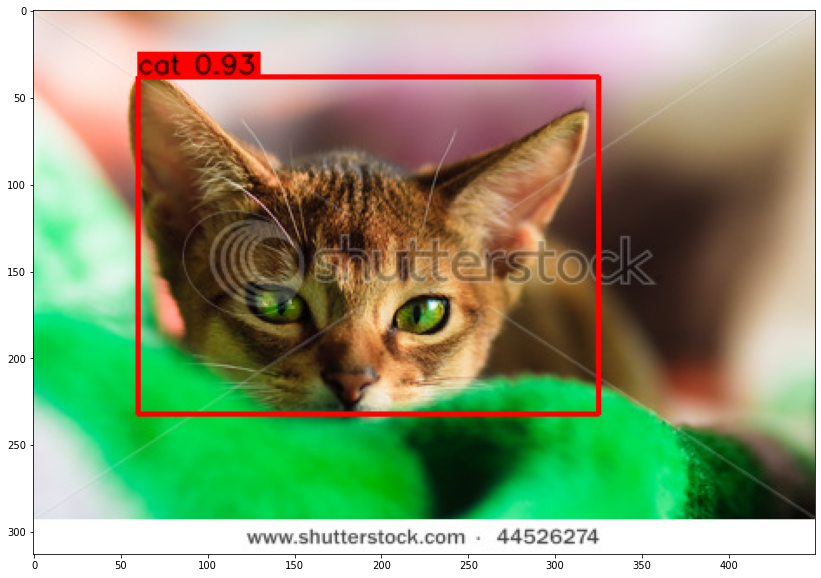

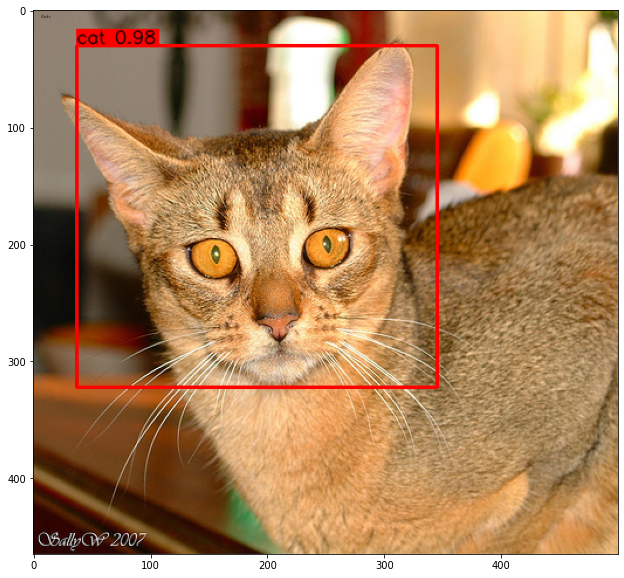

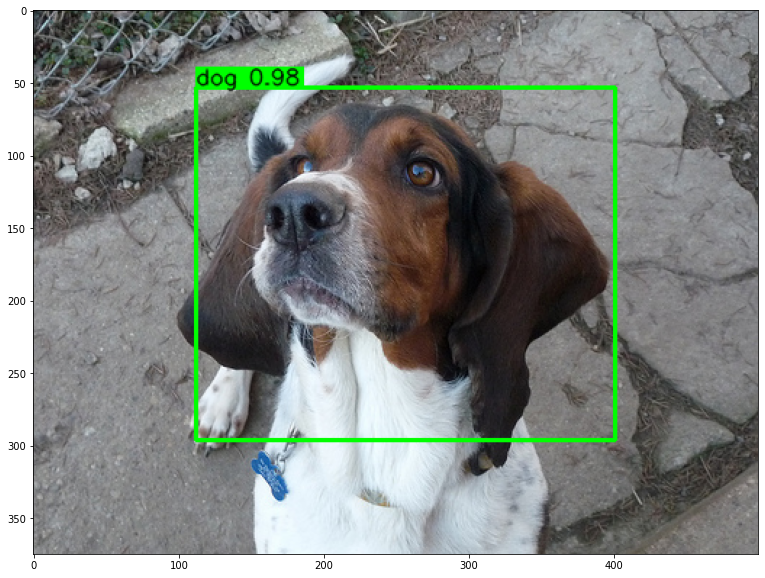

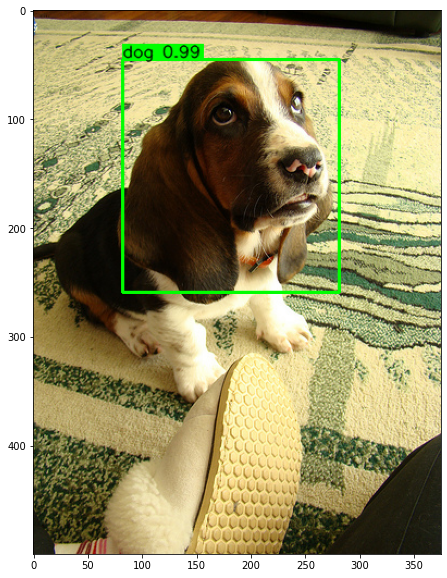

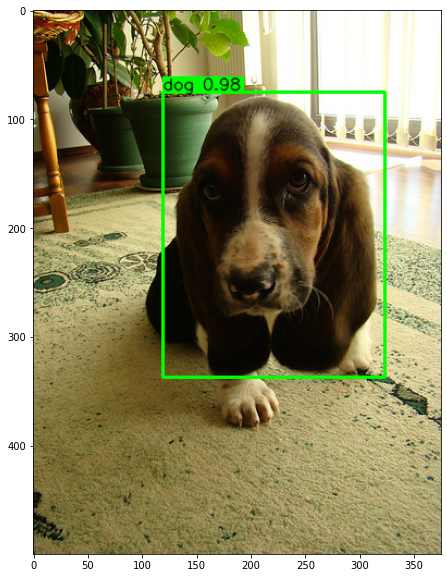

In [ ]:
device = 'cpu'
model.to(device)

model.eval()
for imgfile in sorted(glob(test_path+'/*')):
    img = cv2.imread(imgfile)
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_tensor = torchvision.transforms.functional.to_tensor(img)

    with torch.no_grad():
        prediction = model([image_tensor.to(device)])

    for i,box in enumerate(prediction[0]['boxes']):
        score = prediction[0]['scores'][i].cpu().numpy()
        if score > 0.5:
            score = round(float(score),2)
            cat = prediction[0]['labels'][i].cpu().numpy()
            txt = '{} {}'.format(classes[int(cat)], str(score))
            font = cv2.FONT_HERSHEY_SIMPLEX
            cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
            c = colors[int(cat)]
            box=box.cpu().numpy().astype('int')
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), c , 2)
            cv2.rectangle(img,(box[0], box[1] - cat_size[1] - 2),(box[0] + cat_size[0], box[1] - 2), c, -1)
            cv2.putText(img, txt, (box[0], box[1] - 2), font, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)


    plt.figure(figsize=(15,10))
    plt.imshow(img)
plt.show()